In [2]:
import copy
import json
import os
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np

# shap displays NumbaDeprecationWarning when importing -- supress them
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

import shap
import torch
from torch import Tensor, sigmoid

import logging
# do not display logging messages whatsoever
logging.disable(logging.CRITICAL)

# correct path to repository root
if os.path.basename(os.getcwd()) == "scripts":
    REPOSITORY_ROOT = os.path.join(os.getcwd(), "..")
elif os.path.basename(os.getcwd()) == "adversarial":
    REPOSITORY_ROOT = os.path.join(os.getcwd(), "..", "..")
else:
    REPOSITORY_ROOT = os.getcwd()
sys.path.append(REPOSITORY_ROOT)

from nebula import PEDynamicFeatureExtractor
from nebula.models.attention import TransformerEncoderOptionalEmbedding
from nebula.preprocessing import JSONTokenizerNaive, JSONTokenizerBPE

from scripts.attack.tgd import TokenGradientDescent

from nebula.misc import fix_random_seed
fix_random_seed(0)

TOKENIZER_PATH = os.path.join(REPOSITORY_ROOT, "nebula", "objects", "speakeasy_BPE_50000_sentencepiece_vocab.json")

def compute_score(llm, x, verbose=True):
    logit = llm(x)
    prob = sigmoid(logit)
    if verbose:
        print(f"\n[!!!] Probability of being malicious: {prob.item():.3f} | Logit: {logit.item():.3f}")
    return prob.item()


def load_tokenizer():
    with open(TOKENIZER_PATH) as f:
        vocab = json.load(f)

    tokenizer = JSONTokenizerBPE(
        vocab_size=len(vocab),
        seq_len=512,
        model_path=os.path.join(REPOSITORY_ROOT, "nebula", "objects", "speakeasy_BPE_50000_sentencepiece.model"),
    )
    return tokenizer

def tokenize_sample(report_path, encode=True):
    extractor = PEDynamicFeatureExtractor()
    filtered_report = extractor.filter_and_normalize_report(report_path)
    tokenizer = load_tokenizer()
    tokenized_report = tokenizer.tokenize(filtered_report)
    if encode:
        encoded_report = tokenizer.encode(filtered_report, pad=True, tokenize=True)
        x = Tensor(encoded_report).long()
        return x
    else:
        return tokenized_report


def embed(llm_model, report, device="cpu"):
    src = tokenize_sample(report)
    s = llm_model.split(src)
    s = s.to(device)
    e = llm_model.embed(s)
    return e


def plot_shap_values(shap_values: np.ndarray, name: str):
    shap_values = shap_values.mean(axis=2)
    pos_idx = shap_values[0] >= 0
    neg_index = shap_values[0] < 0
    pos_shap = copy.deepcopy(shap_values)[0]
    pos_shap[neg_index] = 0
    neg_shap = copy.deepcopy(shap_values)[0]
    neg_shap[pos_idx] = 0
    x = range(512)
    plt.bar(x, pos_shap)
    plt.bar(x, neg_shap)
    plt.title(name)
    plt.show()


def load_model(skip_embedding=False, model_idx=0):
    model_path = os.path.join(REPOSITORY_ROOT, r"evaluation\MaskedLanguageModeling\pretrain_epoch_analysis\uSize_0.8_1674855395\downstreamTask_pretrained\training_files")
    pretrained_model = os.path.join(REPOSITORY_ROOT, model_path, [x for x in os.listdir(model_path) if x.endswith("torch")][model_idx])
    vocabFile = TOKENIZER_PATH
    with open(vocabFile, 'r') as f:
        vocab = json.load(f)
    vocab_size = len(vocab) # adjust it to exact number of tokens in the vocabulary
    model_config = {
        "vocab_size": vocab_size,
        "maxlen": 512,
        "chunk_size": 64,  # input splitting to chunks
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1,  # binary classification
        "hiddenNeurons": [64],  # classifier ffnn dims
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True,
        "skip_embedding": skip_embedding
    }
    state_dict = torch.load(pretrained_model, map_location='cpu')
    llm = TransformerEncoderOptionalEmbedding(**model_config)
    # in state_dict drop weights and bias of preTrainLayers
    state_dict = {k: v for k, v in state_dict.items() if "preTrainLayers" not in k}
    llm.load_state_dict(state_dict)
    llm.eval()
    return llm


def analyse_folder(folder: pathlib.Path, llm_model, embed_baseline, name, plot=True, verbose=True):
    filepaths = []
    explanations_arr = []
    for i, report in enumerate(folder.glob("*.json")):
        print(report.name)
        x_embed = embed(llm_model, str(report))
        prob = compute_score(llm_model, x_embed, verbose=verbose)
        explainer = shap.GradientExplainer(model_no_embed, data=embed_baseline)
        explanations = explainer.shap_values(x_embed, nsamples=50)
        if plot:
            plot_shap_values(explanations, f"{name}_{i} : {prob:.3f}")
        explanations_arr.append(explanations)
        filepaths.append(report.name)
    return filepaths, explanations_arr

DEVICE = "cpu"

model = load_model()
model_no_embed = load_model(skip_embedding=True)

malware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "malware"))
goodware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "goodware"))

baseline_report = os.path.join(REPOSITORY_ROOT, r"emulation", "report_baseline.json")

x_baseline = tokenize_sample(baseline_report)
x_embed_baseline = embed(model, baseline_report)


[!!!] MALWARE FOLDER
0a0358122fbf7713bc100f9d0757747e991079c1f7a393aacb5c1fcbe1ff7065.dat.json

[!!!] Probability of being malicious: 0.492 | Logit: -0.034


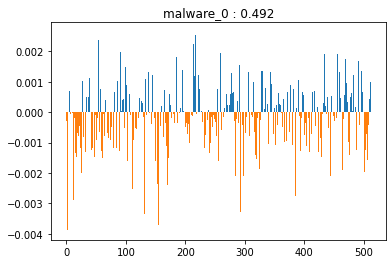

0a677fb789978cdd22f6c0c66a5cf01a9e2fd6d9fcb6484b2385d9354f0632f2.dat.json

[!!!] Probability of being malicious: 0.828 | Logit: 1.570


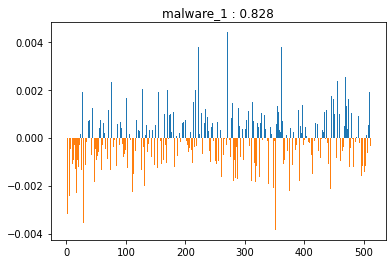

0a711ca925166cadd3c73802b3ba569bf6a6f951fded4c60ccc6ecc2c756473d.dat.json

[!!!] Probability of being malicious: 0.882 | Logit: 2.011


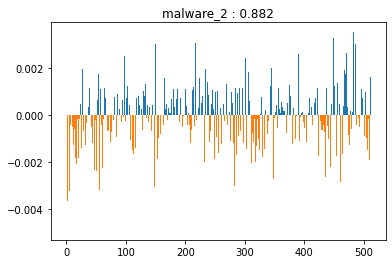

0afa6b5d80f2f3a56c9144d2033b3ea168abb86bbe5e26bc71eccbcf8a0be93a.dat.json

[!!!] Probability of being malicious: 0.987 | Logit: 4.356


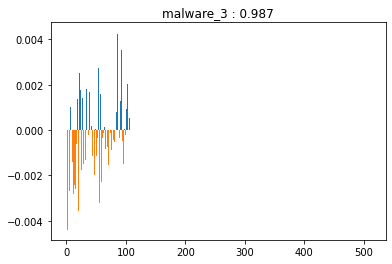

0b1e9a9d060e20685b2718d0a6667e76459ca141ea062b883873ceaa16afb5d9.dat.json

[!!!] Probability of being malicious: 0.906 | Logit: 2.261


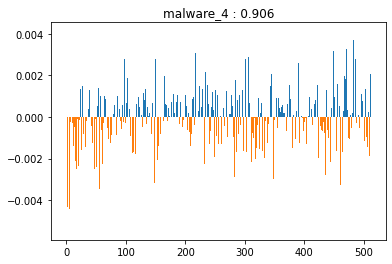

0b30e9492b3d43bddf9be4d2f29441f2318b2958e37cfda8efc07f5257c949c9.dat.json

[!!!] Probability of being malicious: 0.848 | Logit: 1.718


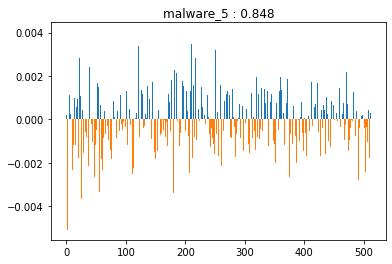

0b6a25fdef6575f6aea7941c63a8a0a740a6754acae7d32f5a590dcae01d27fc.dat.json

[!!!] Probability of being malicious: 0.838 | Logit: 1.643


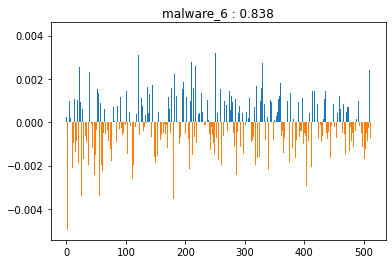

0b6c3923a7d34f3062dab70853887a2a3c8bdb009e9a110d4a554bef892b26fd.dat.json

[!!!] Probability of being malicious: 0.950 | Logit: 2.954


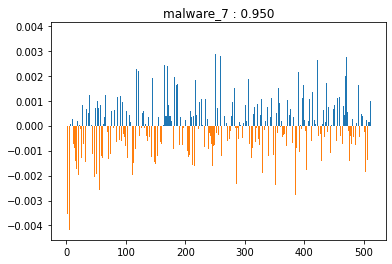


[!!!] GOODWARE FOLDER
0a0ba23720d5afda91ccb93bda9e560473cce055bf2f516d36cc23a9c3a42e60.dat.json

[!!!] Probability of being malicious: 0.900 | Logit: 2.194


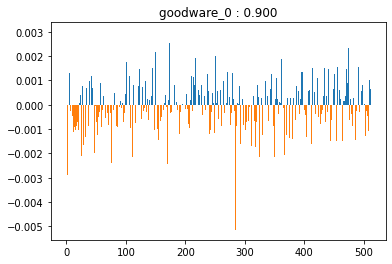

0a1e8fd4416c21fa74171048a53eaeeb958d77b1c44986633110c01c0c91b38e.dat.json

[!!!] Probability of being malicious: 0.966 | Logit: 3.361


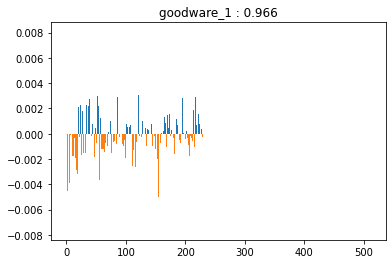

0a2b0354ac9b5ec2967412f0577f2f803b93693283101b417eba342ce1205eaa.dat.json

[!!!] Probability of being malicious: 0.557 | Logit: 0.230


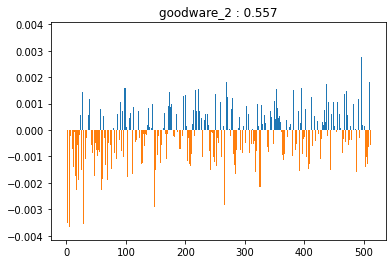

0a3bbeb27e09ef22c94f7440d07bedde479e0e9f122fe51b6f86b4634120221b.dat.json

[!!!] Probability of being malicious: 0.837 | Logit: 1.635


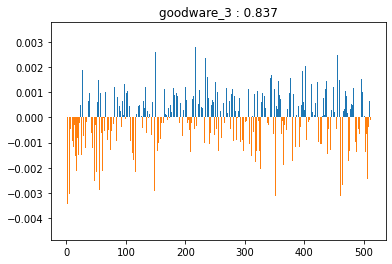

0a4a72fe3cc032f6270ffbd460bb1e68ef005795334e3e478e95965469591681.dat.json

[!!!] Probability of being malicious: 0.924 | Logit: 2.498


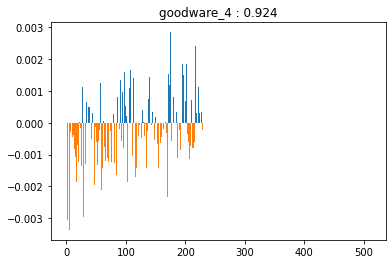

0a4e5a5bb11126116ea610019c1ec5ee5d3a3312dfa1975f94acc13eb1545d58.dat.json

[!!!] Probability of being malicious: 0.704 | Logit: 0.866


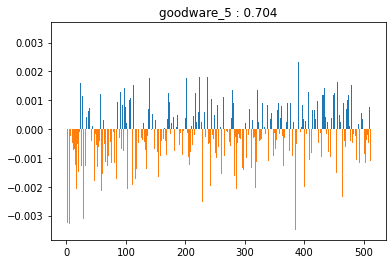

0a57cc32471142bd98fd1aa1004826a03edfef99698d990cd4c5a746c78a65ff.dat.json

[!!!] Probability of being malicious: 0.956 | Logit: 3.086


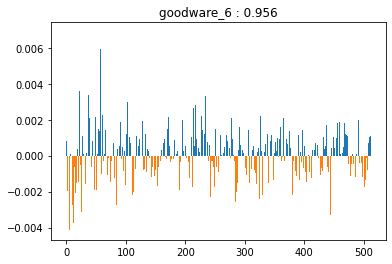

0a5efb412ca54bce23961cef891c28e0e76a5bef2aa776f35374f4d7bfec9aa5.dat.json

[!!!] Probability of being malicious: 0.952 | Logit: 2.997


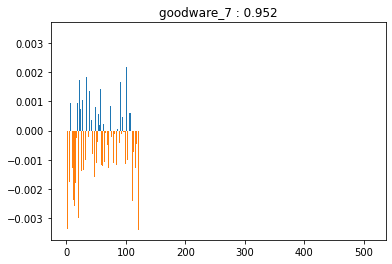

In [5]:
print(f"\n[!!!] MALWARE FOLDER")
filepaths, explanations = analyse_folder(malware_folder, model_no_embed, x_embed_baseline, "malware")

print(f"\n[!!!] GOODWARE FOLDER")
_ = analyse_folder(goodware_folder, model_no_embed, x_embed_baseline, "goodware")

In [9]:
import copy
import logging
from pathlib import Path
from typing import Callable, Union

import torch
from torch import autograd
from torch.nn import Softmax
from torch import sigmoid

from nebula import PEDynamicFeatureExtractor
from nebula.models.attention import TransformerEncoderOptionalEmbedding
from nebula.preprocessing.json import JSONTokenizerNaive, JSONTokenizerBPE

INVALID = torch.inf


def token_gradient_descent(
        embedding_tokens: torch.Tensor,
        gradient_f: torch.Tensor,
        i: int, x: torch.Tensor,
        admitted_tokens: torch.LongTensor,
        unavailable_tokens: Union[torch.Tensor, None] = None
) -> int:
    gradient_f_i = gradient_f[0, i]
    x_i = x[0, i]
    token_to_chose = single_token_gradient_update(
        start_token=x_i.cpu(),
        gradient=gradient_f_i.cpu(),
        embedded_tokens=embedding_tokens.cpu(),
        admitted_tokens=admitted_tokens.cpu(),
        unavailable_tokens=unavailable_tokens
    )
    return token_to_chose


def single_token_gradient_update(
        start_token: torch.Tensor,
        gradient: torch.Tensor,
        embedded_tokens: torch.Tensor,
        admitted_tokens: torch.LongTensor,
        invalid_val=INVALID,
        unavailable_tokens: Union[torch.Tensor, None] = None
):
    """
    Given the starting byte, the gradient and the embedding map,it returns a list of distances

    Parameters
    ----------
    start_token : int
        the starting embedding token for the search
    gradient : torch.Tensor
        the gradient of a single embedded token
    embedded_tokens : torch.Tensor
        the embedding matrix with all the byte embedded
    admitted_tokens: list
        the list of indexes of the tokens to use in the search
    invalid_val : optional, default torch.inf
        the invalid value to use. Default torch.inf
    unavailable_tokens: Union[torch.Tensor, None] = None
        if specified, it avoids the usage of the selected tokens during the search step
    Returns
    -------

    """
    if torch.equal(gradient, torch.zeros(gradient.shape)):
        invalid_distances = torch.tensor([invalid_val] * embedded_tokens.shape[0])
        return invalid_distances
    distance = torch.zeros(len(admitted_tokens))
    gs = gradient / torch.norm(gradient)  # MAXIMISING the error of the real class
    for i, b in enumerate(embedded_tokens[admitted_tokens, :].cpu()):
        if torch.all(start_token == b):
            distance[i] = invalid_val
            continue
        if unavailable_tokens is not None:
            if i in unavailable_tokens:
                distance[i] = INVALID
        bts = b - start_token
        s_i = torch.dot(gs, bts)
        if s_i <= 0:
            distance[i] = invalid_val
        else:
            d_i = torch.norm(b - (start_token + s_i * gs))
            distance[i] = d_i
    min_value, token_index = torch.min(distance, dim=0, keepdim=True)
    if min_value == INVALID:
        return INVALID
    token_to_chose = admitted_tokens[token_index]
    return token_to_chose


class TokenGradientDescent:
    def __init__(self, model: TransformerEncoderOptionalEmbedding,
                 tokenizer: Union[JSONTokenizerNaive, JSONTokenizerBPE],
                 step_size: int,
                 steps: int,
                 index_token_to_use: list,
                 probability_function: Callable[[torch.Tensor], torch.Tensor] = sigmoid,
                 token_index_to_avoid=None,
                 n_tokens=50000,
                 loss=Softmax(),
                 device="cpu",
                 verbose=False):
        if token_index_to_avoid is None:
            token_index_to_avoid = [0, 1, 2]
        self.model = model
        self.step_size = step_size
        self.steps = steps
        self.index_token_to_use = index_token_to_use
        self.tokenizer = tokenizer
        self.probability = probability_function
        self.token_index_to_avoid = token_index_to_avoid
        self.n_tokens = n_tokens
        self.embedded_tokens = None
        self.loss_function = loss
        self.device = device
        self.verbose = verbose

        assert isinstance(self.tokenizer, JSONTokenizerNaive) or \
            isinstance(self.tokenizer, JSONTokenizerBPE), \
            "Tokenizer must be a JSONTokenizerNaive or JSONTokenizerBPE"

    def optimization_solver(
            self,
            embedding_tokens: torch.Tensor,
            gradient_f: torch.Tensor,
            x: torch.Tensor,
            admitted_tokens: torch.LongTensor,
            to_avoid: Union[torch.Tensor, None] = None,
            unavailable_tokens: Union[torch.Tensor, None] = None
    ) -> torch.Tensor:
        """
        Optimizes the end-to-end evasion

        Parameters
        ----------
        embedding_tokens : torch.Tensor
            the embedding matrix E, with all the embedded values
        gradient_f : torch.Tensor
            the gradient of the function w.r.t. the embedding
        x : torch.Tensor
            the input sample to manipulate
        admitted_tokens: list
            the list of index of token to use during the optimization
        to_avoid: Union[torch.Tensor,None] = None
            if specified, it avoids manipulating specified entries in input sample
        unavailable_tokens: Union[torch.Tensor,None] = None
            if specified, it avoids using specified tokens in token gradient descent step
        Returns
        -------
        torch.Tensor
            the adversarial malware
        """
        grad_norms = gradient_f.norm(dim=-1).squeeze()
        grad_norms = grad_norms.cpu()
        indexes_to_perturb = [i for i in range(self.model.max_input_length)]
        if to_avoid is not None:
            grad_norms[to_avoid] = 0
        indexes_to_perturb = torch.LongTensor(indexes_to_perturb)
        best_indexes = grad_norms.argsort(descending=True)
        indexes_to_perturb = indexes_to_perturb[best_indexes]
        results = torch.zeros((len(best_indexes))) + INVALID
        for i, index in enumerate(best_indexes[:self.step_size]):
            results[i] = token_gradient_descent(
                embedding_tokens,
                gradient_f,
                index,
                x,
                admitted_tokens,
                unavailable_tokens
            )

        to_edit = indexes_to_perturb[results != INVALID]
        x[0, to_edit] = embedding_tokens[results[results != INVALID].long()]
        return x

    def embed_all_tokens(self):
        windows = int(self.n_tokens // self.model.max_input_length)
        tokens = torch.LongTensor(list(range(self.n_tokens)))
        tokens = tokens.to(self.device)
        embedded_tokens = torch.zeros((self.n_tokens, self.model.d_model))
        embedded_tokens = embedded_tokens.to(self.device)
        for i in range(windows + 1):
            start = self.model.max_input_length * i
            stop = self.model.max_input_length * (i + 1)
            to_embed = tokens[start: stop]
            embedded = self.model.embed(to_embed.unsqueeze(dim=0))
            embedded_tokens[start: stop, :] = embedded
        self.embedded_tokens = embedded_tokens[:self.n_tokens, :]
        return self.embedded_tokens

    def tokenize_sample(self, report, encode=True):
        extractor = PEDynamicFeatureExtractor()
        filtered_report = extractor.filter_and_normalize_report(report)
        tokenized_report = self.tokenizer.tokenize(filtered_report)
        if encode:
            if isinstance(self.tokenizer, JSONTokenizerBPE):
                encoded_report = self.tokenizer.encode(filtered_report, pad=True, tokenize=True)
            if isinstance(self.tokenizer, JSONTokenizerNaive):
                encoded_report = self.tokenizer.encode(tokenized_report, pad=True, tokenize=False)
            x = torch.Tensor(encoded_report).long()
            return x
        return tokenized_report

    def __call__(
            self,
            x: Union[torch.Tensor, str],
            y: float, return_additional_info=False,
            input_index_locations_to_avoid=None
    ):
        if isinstance(x, str) or isinstance(x, Path):
            x = self.tokenize_sample(x)
        x_adv: torch.Tensor = copy.deepcopy(x.detach())
        x_adv = x_adv.to(self.device)
        x_adv = self.model.embed(x_adv)
        x_adv.requires_grad_()
        embedded_tokens = self.embed_all_tokens()
        loss_seq = torch.zeros((self.steps, 1))
        confidence_seq = torch.zeros((self.steps, 1))
        x_path = torch.zeros((self.steps, *x_adv.shape[1:]))
        if self.verbose:
            logging.log(logging.INFO, "- " * 10)
            logging.log(logging.INFO, "Starting TGD")
        for i in range(self.steps):
            output = self.model(x_adv)
            loss = y - sigmoid(output)
            if self.verbose:
                logging.log(logging.INFO, f"Iteration {i} - Loss : {loss.item()}")
            grad_adv_x = autograd.grad(loss, x_adv)[0]
            x_adv = self.optimization_solver(
                embedding_tokens=embedded_tokens,
                gradient_f=grad_adv_x,
                x=x_adv,
                admitted_tokens=torch.LongTensor(self.index_token_to_use),
                to_avoid=input_index_locations_to_avoid,
                unavailable_tokens=self.token_index_to_avoid
            )
            loss_seq[i] = loss.item()
            confidence_seq[i] = sigmoid(output).cpu()
            x_path[i] = copy.deepcopy(x_adv.cpu().detach())
        adv_index = torch.argmax(loss_seq.flatten())
        final_x_adv = x_path[adv_index]
        if return_additional_info:
            return final_x_adv.detach().cpu(), loss_seq.detach().cpu(), confidence_seq.detach().cpu(), x_path.detach().cpu()
        return final_x_adv


def compute_adv_exe_from_folder(folder: pathlib.Path, llm_model, verbose: bool = False):
    token_to_use = list(range(200, 1000))
    tokenizer = load_tokenizer()
    tgd_attack = TokenGradientDescent(
        model=llm_model,
        tokenizer=tokenizer,
        step_size=32,
        steps=10,
        index_token_to_use=token_to_use,
        token_index_to_avoid=[0, 2],
        n_tokens=tokenizer.vocab_size,
        verbose=verbose,
        device=DEVICE
    )
    for i, report in enumerate(folder.glob("*.json")):
        print(report.name)
        x_embed = embed(llm_model, str(report), device=DEVICE)
        y = torch.sign(llm_model(x_embed))
        y = y.item()
        to_avoid = list(range(0, 250)) # faking impossible locations to manipulate
        final_x_adv, loss_seq, confidence_seq, x_path = tgd_attack(str(report), y, return_additional_info=True,
                                                                   input_index_locations_to_avoid=to_avoid)
        fig, ax = plt.subplots()

        ax.plot(confidence_seq, label="confidence")
        ax.scatter(range(len(confidence_seq)), confidence_seq)
        ax.set_ylabel("confidence")

        ax.plot(loss_seq, label="loss")
        ax.scatter(range(len(loss_seq)), loss_seq)
        ax.twinx().set_ylabel('loss')

        ax.set_xlabel("steps")
        ax.legend()
        plt.show()

compute_adv_exe_from_folder(malware_folder, model_no_embed, verbose=True)


0a0358122fbf7713bc100f9d0757747e991079c1f7a393aacb5c1fcbe1ff7065.dat.json


RuntimeError: expand(torch.FloatTensor{[50002]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)